In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#%reset
import numpy as np
import argparse
import re
import os, glob, datetime
#tensorflow==2.1.0
#tensorflow-estimator==2.1.0
import tensorflow as tf
import numpy as np
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
#import data_generator as dg
import keras.backend as K
import sys
sys.path.insert(0, "/content/drive/MyDrive/VAE/modules")
sys.path.append('/content/drive/My Drive/VAE/utils')
print(sys.path)

['/content/drive/MyDrive/VAE/modules', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/VAE/utils']


In [ ]:
# Model configuration
patch_size=40
#img_width, img_height = patch_size, patch_size
img_width, img_height = 181, 217
bands=6
#batch_size = 150
batch_size = 25
print("hey there!")
no_epochs = 50
validation_split = 0.2
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.55
number_of_visualizations = 6

In [ ]:
# Code for converting 2d multipsectral CAVE dataset images into 1 3d image
from PIL import Image
import numpy as np
# load the image
image = Image.open('/content/drive/My Drive/VAE/data/HSI/CAVE/watercolors_ms/watercolors_ms_' +'01'+ '.png')
data=np.empty((512,512,31))
data[:,:,0]=np.asarray(image)
print(data.shape)
for i in range(1,31):
    a=format(i,"0>2d")
    image = Image.open('/content/drive/My Drive/VAE/data/HSI/CAVE/watercolors_ms/watercolors_ms_' +a+ '.png')
    data[:,:,i]=np.asarray(image)
    
print(data.shape)
np.save('/content/drive/My Drive/VAE/data/HSI/CAVE/CAVE3d_32',data)

In [ ]:
import numpy as np
from mri_preprocess import *
from keras.models import load_model
# Load 3D data from CAVE datasets (numbered 1 to 25)
i=1
img3d=np.load('/content/drive/My Drive/VAE/data/HSI/CAVE/CAVE3d_'+format(i,"0>2d")+'.npy')
a=mri_3d_extract(img3d,patch_size=40,channels=1) # to extract 2d data (no. of channels=1)
#a=mri_3d_extract(img3d,patch_size=40,channels=6) # to extract 3d data (no. of channels=more)
for i in range(1,5):
  img3d=np.load('/content/drive/My Drive/VAE/data/HSI/CAVE/CAVE3d_'+format(i+1,"0>2d")+'.npy')
  patches=mri_3d_extract(img3d,patch_size=40,channels=1) # to extract 2d data (no. of channels=1)
  #patches=mri_3d_extract(img3d,patch_size=40,channels=6) # to extract 3d data (no. of channels=more)
  a=np.concatenate([a,patches])
print(a.shape)
##############################################################################################

#a=np.load('/content/drive/My Drive/VAE/data/HSI/CAVE/balloons_ms/balloons3DPatches.npy')

img_width,img_height,layers=patch_size,patch_size,bands
#Reshaping data  
if K.image_data_format() == 'channels_first':
    print("channel first format")
    # Considering 3D data
    #input_train = a.reshape(a.shape[0], 1, img_width, img_height,layers)
    #input_shape = (1, img_width, img_height,layers)
    
    # Considering 2D data
    input_train = a.reshape(a.shape[0], 1, img_width, img_height)
    input_shape = (1, img_width, img_height)
else:
    print("channel last format")
    
    # Considering 3D data
    #input_train = a.reshape(a.shape[0], img_width, img_height,layers,1)
    #input_shape = (img_width, img_height, layers, 1)
    
    #Considering 2D data
    input_train = a.reshape(a.shape[0], img_width, img_height,1)
    input_shape = (img_width, img_height, 1)

In [ ]:
#################### Normalize Input Data ##########################

print(a.shape)
print(input_train[0].shape)
numOfSamples= input_train.shape[0]
for i in range(numOfSamples):
    # Normalise data between [0,1] (for each sample)
    input_train[i] = (input_train[i] - np.min(input_train[i]))/np.ptp(input_train[i])
    # Normalise data between[0,255] (per sample) as integer: don't forget the parenthesis before astype(int)
    #input_train[i] = (255*(input_train[i] - np.min(input_train[i]))/np.ptp(input_train[i])).astype(int)        

In [ ]:
print(input_train[0].shape)

In [ ]:
# Add noise
from numpy.random import seed
from numpy.random import randint
from mri_preprocess import *

#print(randint(1,5,1))

pure_train = input_train

# for 2D data
noisy_input_train=add_gaussian_noise(input_train,10)
noisy_input_train=add_impulse_noise(noisy_input_train,20)

# for 3d data
#noisy_input_train=add_gaussian_noise3D(input_train,10)
#noisy_input_train=add_impulse_noise3D(noisy_input_train,20)
#noisy_input_test=noisy_input_test.astype('float32')
print(noisy_input_train.shape)

In [ ]:
#################### Normalize Noisy Data ##########################

print(a.shape)
print(input_train[0].shape)
numOfSamples= input_train.shape[0]
for i in range(numOfSamples):
    # Normalise data between [0,1] (for each sample)
    noisy_input_train[i] = (noisy_input_train[i] - np.min(noisy_input_train[i]))/np.ptp(noisy_input_train[i])
    # Normalise data between[0,255] (per sample) as integer: don't forget the parenthesis before astype(int)
    #input_train[i] = (255*(input_train[i] - np.min(input_train[i]))/np.ptp(input_train[i])).astype(int)  

#print(input_train[0].shape)      

In [ ]:
# -*- coding: utf-8 -*-

import numpy as np
#import tensorflow as tf
from keras.models import *
from keras.layers import  Input,Conv2D,Conv3D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge

import keras.backend  as K
#from group_norm import GroupNormalization #
#from batch_renorm import BatchRenormalization
#def BRDNet(): #original format def BRDNet(), data is used to obtain the reshape of input data
#inpt = Input(shape=(None,None,None, 1)) #if the image is 3, it is color image. If the image is 1, it is gray color, 201807082123tcw
inpt = Input(shape=(None,None, 1)) #if the image is 3, it is color image. If the image is 1, it is gray color, 201807082123tcw
# 1st layer, Conv+relu
#x = Conv3D(filters=128, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(inpt)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
#x = BatchRenormalization(axis=-1, epsilon=1e-3)(x)
x = BatchNormalization(axis=-1, epsilon=1e-3,renorm=1)(x)
x = Activation('relu')(x)
# 15 layers, Conv+BN+relu
for i in range(7):
    #x = Conv3D(filters=128, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    #x = BatchRenormalization(axis=-1, epsilon=1e-3)(x)
    x = BatchNormalization(axis=-1, epsilon=1e-3,renorm=1)(x)
    x = Activation('relu')(x)   
# last layer, Conv 
for i in range(8):
    #x = Conv3D(filters=128, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    #x = BatchRenormalization(axis=-1, epsilon=1e-3)(x)
    x = BatchNormalization(axis=-1, epsilon=1e-3,renorm=1)(x)
    x = Activation('relu')(x) 
#x = Conv3D(filters=1, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(x) #gray is 1 color is 3
x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x) #gray is 1 color is 3
x = Subtract()([inpt, x])   # input - noise
#y = Conv3D(filters=128, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(inpt)
y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
#y = BatchRenormalization(axis=-1, epsilon=1e-3)(y)
y = BatchNormalization(axis=-1, epsilon=1e-3,renorm=1)(y)
y = Activation('relu')(y)
# 15 layers, Conv+BN+relu
for i in range(7):
    #y = Conv3D(filters=128, kernel_size=(3,3,3), strides=(1,1,1),dilation_rate=(2,2,2), padding='same')(y)
    y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),dilation_rate=(2,2), padding='same')(y)
    y = Activation('relu')(y)   
#y = Conv3D(filters=128, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(y)
y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(y)
#y = BatchRenormalization(axis=-1, epsilon=1e-3)(y)
y = BatchNormalization(axis=-1, epsilon=1e-3,renorm=1)(y)
y = Activation('relu')(y) 
for i in range(6):
    #y = Conv3D(filters=64, kernel_size=(3,3,3), strides=(1,1,1),dilation_rate=(2,2,2), padding='same')(y)
    y = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1),dilation_rate=(2,2), padding='same')(y)
    y = Activation('relu')(y)
#y = Conv3D(filters=128, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(y)
y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(y)
#y = BatchRenormalization(axis=-1, epsilon=1e-3)(y)
y = BatchNormalization(axis=-1, epsilon=1e-3,renorm=1)(y)
y = Activation('relu')(y)    
#y = Conv3D(filters=1, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(y)#gray is 1 color is 3
y = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(y)#gray is 1 color is 3
y = Subtract()([inpt, y])   # input - noise
o = concatenate([x,y],axis=-1)
#z = Conv3D(filters=1, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(o)#gray is 1 color is 3
z = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(o)#gray is 1 color is 3
z=  Subtract()([inpt, z])
model = Model(inputs=inpt, outputs=z)
#model.summary()
#return model

In [ ]:
from ganModel import *
model = generator_model()

In [3]:
#from losses import ssim_loss
#from mymetrics import ssim_metric,psnr_metric,ssim_loss
from keras.losses import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import skimage.metrics
import pytorch_ssim
import torch
from torch.autograd import Variable
from skimage import measure
import math
def ssim_metric2d(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

def ssim_metric3d(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0,filter_size=5))

def psnr_metric(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * K.log(K.mean(K.square(y_pred - y_true)))
def psnr_met1(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

# Loss functtion
def ssim_loss1(y_true, y_pred):
    myssim=tf.image.ssim(y_true, y_pred,1)
    s_3d_tf = tf.Session().run(myssim)
    return tf.reduce_mean((1.0-s_3d_tf)/2.0)

def ssim_loss2(y_true, y_pred):
    print(y_true.dtype)
    img1=torch.cuda.FloatTensor(y_true)
    img2=torch.cuda.FloatTensor(y_pred)
    #img1=tf.convert_to_tensor(y_true)
    #img2=tf.convert_to_tensor(y_pred)
    print(img1.dtype)
    print(img2.shape)
    ssim_3d_sk=pytorch_ssim.ssim3D(y_true, y_pred)
    #ssim_3d_sk = skimage.metrics.structural_similarity(y_true, y_pred, multichannel=False, gaussian_weights=True, data_range=1.0, use_sample_covariance=False)
    #ssim_3d_sk = ssim(img1, img2,win_size=3, gaussian_weights=True, data_range=1.0, use_sample_covariance=False)
    return tf.reduce_mean((1.0-ssim_3d_sk)/2.0)

# Loss functtion
def ssim_loss2d(y_true, y_pred):
    return tf.reduce_mean((1.0-tf.image.ssim(y_true, y_pred,1))/2.0)

def ssim_loss3d(y_true, y_pred):
    return tf.reduce_mean((1.0-tf.image.ssim_multiscale(y_true, y_pred,1,filter_size=7))/2.0)

def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(ssim(y_true, y_pred))

def psnr_met2(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 * (1.0 / math.log(10)) * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))

def L2_SSIM_loss(y_true, y_pred):
  alpha=0.5
  return alpha*mean_squared_error(y_true, y_pred) + (1.0-alpha)* ssim_loss(y_true, y_pred) 

def L1_SSIM_loss(y_true, y_pred):
  alpha=0.5
  return alpha*mean_absolute_error(y_true, y_pred) + (1.0-alpha)* ssim_loss(y_true, y_pred) 

def total_content_loss2d(y_true,y_pred):
  alpha=0.3
  tv_weight=1e-5
  '''
  Total variation loss is used to keep the image locally coherent
   '''
  #assert K.ndim(x) == 4
  a = tf.square(y_pred[:, :-1, :-1, :] - y_pred[:, 1:, :-1, :])
  b = tf.square(y_pred[:, :-1, :-1, :] - y_pred[:, :-1, 1:, :])
  #a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
  #b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
  return tv_weight*K.sum(K.pow(a + b,1.25))+alpha*mean_squared_error(y_true,y_pred)+(1-alpha)*mean_absolute_error(y_true,y_pred)

def L2_L1_loss(y_true,y_pred):
  alpha=0.4
  return alpha*mean_squared_error(y_true,y_pred)+(1-alpha)*mean_absolute_error(y_true,y_pred)

def mse_TV(y_true,y_pred):
  tv_weight=1e-5
  mse_weight=0.5
  return mse_weight*mean_squared_error(y_true,y_pred)+tv_weight*total_variation_loss(y_pred)


In [ ]:
custom_objects={'ssim_metric': ssim_metric,'psnr_met2':psnr_met2,'ssim_loss':ssim_loss}
model=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL3D-G10I20_040_MSE.h5',custom_objects=custom_objects)

In [ ]:
# Compile and fit data
from keras.callbacks import CSVLogger
from keras import losses
from keras import optimizers
from mymetrics import *
from ganModel import *
import keras
#from mymetrics import ssim_metric,psnr_met2,ssim_loss
csv_logger = CSVLogger('/content/drive/My Drive/VAE/logs/HSI-logs/logfile-RL2DG10I20_epoch200-L2L1TV-spl-renorm.log', separator=',', append=False)
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/VAE/models/HSI/EnsRL2D-G10I20_{epoch:03d}_L2L1TV-spl-renorm.h5', period=20)
adam=optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
#sgdm=optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=True)
#adam = optimizers.adam(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss=losses.mean_square_error, optimizer=adam)
#model=generator_model()
#residual_train.astype('float32')
#print(np.max(residual_train))
model.compile(optimizer=adam, loss=total_content_loss2d,metrics=[psnr_met2,ssim_metric2d])
model.fit(noisy_input_train, input_train,callbacks=[checkpoint,csv_logger],
               epochs=200,
             batch_size=30,
                validation_split=validation_split)
                

In [ ]:
model.save("/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10.h5")

In [31]:
# Load test image
import numpy as np
from mymetrics import *
from ganModel import *
from mri_preprocess import *
from scipy.io import loadmat


from keras.models import load_model

#img3d=np.load('/content/drive/My Drive/VAE/data/HSI/CAVE/CAVE3d_06.npy')
#img3d=loadmat('/content/drive/MyDrive/VAE/deep-hs-prior/data/denoising/wdcP2.mat')['img'];
img3d=loadmat('/content/drive/My Drive/VAE/deep-hs-prior/data/denoising/Salinas.mat')['salinas'];
#img3d=img3d[:,:,1:2]
print(img3d.shape)
#a=mri_3d_extract(img3d,patch_size=512,channels=31)
a=img3d.reshape(1,img3d.shape[0],img3d.shape[1],img3d.shape[2])
print(a.shape)

img_width,img_height,layers=a.shape[1],a.shape[2],a.shape[3]

#Reshaping data  
if K.image_data_format() == 'channels_first':
    print("channel first format")
    # Considering 3D data
    input_test = a.reshape(1, 1, img_width, img_height,layers)
    input_shape = (1, 1, img_width, img_height,layers)
else:
    print("channel last format")
    # Considering 3D data
    input_test = a.reshape(1, img_width, img_height,layers,1)
    input_shape = (1, img_width, img_height, layers, 1)
    
    # Considering 2D data
    #input_test = a.reshape(1, img_width, img_height,1)
    #input_shape = (1, img_width, img_height, 1)
    


#################### Normalize Data ##########################

# Normalise data between [0,1] (for each sample)
noisy_input_test = (input_test - np.min(input_test))/np.ptp(input_test)
# Normalise data between[0,255] (per sample) as integer: don't forget the parenthesis before astype(int)
#input_train[i] = (255*(input_train[i] - np.min(input_train[i]))/np.ptp(input_train[i])).astype(int)        
print(np.shape(input_test))  

#################### Add noise ##################
from numpy.random import seed
from numpy.random import randint
import sys
nb_path = '/content/drive/MyDrive/VAE/modules'
sys.path.append(nb_path)
from mri_preprocess import *

# Adding noise for 3d data
#noisy_input_test=add_gaussian_noise3D(input_test,20)
#noisy_input_test=add_impulse_noise3D(noisy_input_test,5)

# normalize noisy data
#input_test=np.stack((noisy_input_test[:,:,:,30,0:1],noisy_input_test[:,:,:,24,0:1],noisy_input_test[:,:,:,20,0:1]),3)
#noisy_input_test = (noisy_input_test - np.min(noisy_input_test))/np.ptp(noisy_input_test)
# Adding noise for 2d data
#noisy_input_test=add_gaussian_noise(input_test,10)
#noisy_input_test=add_impulse_noise(noisy_input_test,10)
#noisy_input_test=noisy_input_test.astype('float32')
print(noisy_input_test.shape)

############Denoise 3D data############

print(np.shape(input_test))
print(type(noisy_input_test))
#residual=model.predict(noisy_input_test[94:95])
#model = generator_model()
#model.load_weights('/content/drive/My Drive/VAE/models/HSI/gan3.h5')

(512, 217, 224)
(1, 512, 217, 224)
channel last format
(1, 512, 217, 224, 1)
(1, 512, 217, 224, 1)
(1, 512, 217, 224, 1)
<class 'numpy.ndarray'>


In [32]:
custom_objects={'ssim_metric': ssim_metric,'psnr_met2':psnr_met2,'ssim_loss':ssim_loss,'total_content_loss2d':total_content_loss2d,'ssim_metric2d':ssim_metric2d}
#model1=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2D-G10I20_200_L2L1TV-spl-renorm.h5',custom_objects=custom_objects)
model1=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2D-G10I20_160_MSE-spl-renorm.h5',custom_objects=custom_objects)
#model2=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_020_L1-SSIM.h5',custom_objects=custom_objects)
#model3=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_030_L1-SSIM.h5',custom_objects=custom_objects)
#model4=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_040_L1-SSIM.h5',custom_objects=custom_objects)
#model5=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_050_L1-SSIM.h5',custom_objects=custom_objects)
#model6=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_060_L1-SSIM.h5',custom_objects=custom_objects)
#model7=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_070_L1-SSIM.h5',custom_objects=custom_objects)
#model8=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_080_L1-SSIM.h5',custom_objects=custom_objects)
#model9=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_090_L1-SSIM.h5',custom_objects=custom_objects)
#model10=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_100_L1-SSIM.h5',custom_objects=custom_objects)
#model11=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_110_L1-SSIM.h5',custom_objects=custom_objects)
#model12=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_120_L1-SSIM.h5',custom_objects=custom_objects)
#model13=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_130_L1-SSIM.h5',custom_objects=custom_objects)
#model14=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_140_L1-SSIM.h5',custom_objects=custom_objects)
#model15=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_150_L1-SSIM.h5',custom_objects=custom_objects)
#model16=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_160_L1-SSIM.h5',custom_objects=custom_objects)
#model17=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_170_L1-SSIM.h5',custom_objects=custom_objects)
#model18=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_180_L1-SSIM.h5',custom_objects=custom_objects)
#model19=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_190_L1-SSIM.h5',custom_objects=custom_objects)
#model20=load_model('/content/drive/My Drive/VAE/models/HSI/EnsRL2DG10I10_200_L1-SSIM.h5',custom_objects=custom_objects)

In [40]:
#from scipy.io import loadmat
#img3d=loadmat('/content/drive/My Drive/VAE/data/HSI/wdc.mat')['img'];
#abc=np.array(img3d);
#print(img3d.shape)
#!pip install mat4py
#denoised1=model1.predict(np.stack((noisy_input_test[:,:,:,30,0:1],noisy_input_test[:,:,:,24,0:1],noisy_input_test[:,:,:,20,0:1]),3))
denoised=model1.predict(noisy_input_test[:,:,:,2])
#np.stack((out_np[30,:,:],out_np[20,:,:],out_np[10,:,:]),2)

In [ ]:
abc=np.stack((noisy_input_test[:,:,:,30,0:1],noisy_input_test[:,:,:,24,0:1],noisy_input_test[:,:,:,20,0:1]),3)
print(abc.shape)

In [8]:
import time
denoised=np.empty((input_test.shape))
start_time = time.time()
for i in range(noisy_input_test.shape[3]):
  denoised[:,:,:,i,0:1]=model1.predict(noisy_input_test[:,:,:,i,0:1])
  #denoised1[:,:,:,i,0:1]=model1.predict(input_test[:,:,:,i,0:1])
print("--- %s seconds ---" % (time.time() - start_time))

#denoised2=model2.predict(noisy_input_test[:,:,:,10,0:1])
#denoised3=model3.predict(noisy_input_test[:,:,:,10,0:1])
#denoised4=model4.predict(noisy_input_test[:,:,:,10,0:1])
#denoised5=model5.predict(noisy_input_test[:,:,:,10,0:1])
#denoised6=model6.predict(noisy_input_test[:,:,:,10,0:1])
#denoised7=model7.predict(noisy_input_test[:,:,:,10,0:1])
#denoised8=model8.predict(noisy_input_test[:,:,:,10,0:1])
#denoised9=model9.predict(noisy_input_test[:,:,:,10,0:1])
#denoised10=model10.predict(noisy_input_test[:,:,:,10,0:1])

#denoised11=model11.predict(noisy_input_test[:,:,:,10,0:1])
#denoised12=model12.predict(noisy_input_test[:,:,:,10,0:1])
#denoised13=model13.predict(noisy_input_test[:,:,:,10,0:1])
#denoised14=model14.predict(noisy_input_test[:,:,:,10,0:1])
#denoised15=model15.predict(noisy_input_test[:,:,:,10,0:1])
#denoised16=model16.predict(noisy_input_test[:,:,:,10,0:1])
#denoised17=model17.predict(noisy_input_test[:,:,:,10,0:1])
#denoised18=model18.predict(noisy_input_test[:,:,:,10,0:1])
#denoised19=model19.predict(noisy_input_test[:,:,:,10,0:1])
#denoised20=model20.predict(noisy_input_test[:,:,:,10,0:1])
#print(np.shape(denoised))

--- 33.376373529434204 seconds ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

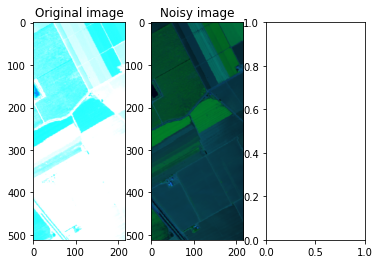

In [36]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.transform import rotate

fig, axes = plt.subplots(1, 3)
#fig, axes = plt.subplots(1, 2)
#axes[0].imshow(rgb2gray(input_test[0,:,:,20,0]),cmap=plt.cm.gray)
axes[0].imshow(np.stack((input_test[0,:,:,208,0],input_test[0,:,:,70,0],input_test[0,:,:,20,0]),2),cmap=plt.cm.gray)
#axes[0].imshow(np.concatenate(input_test[0,:,:,166,0],input_test[0,:,:,110,0],input_test[0,:,:,10,0]))
axes[0].set_title('Original image')
#axes[1].imshow(rgb2gray(noisy_input_test[0,:,:,20,0]),cmap=plt.cm.gray)
axes[1].imshow(np.stack((noisy_input_test[0,:,:,208,0],noisy_input_test[0,:,:,70,0],noisy_input_test[0,:,:,20,0]),2),cmap=plt.cm.gray)
axes[1].set_title('Noisy image')
#axes[2].imshow(denoised1[0,:,:,0],cmap=plt.cm.gray)
axes[2].imshow(np.stack((denoised[0,:,:,208,0],denoised[0,:,:,70,0],denoised1[0,:,:,20,0]),2))
axes[2].set_title('Denoised image')

In [41]:
#print(np.shape(denoised1))
from scipy.io import savemat
savemat('/content/drive/My Drive/VAE/results/HSI/salinas-10-20L3.mat', {'denoised':denoised})
#savemat("den.mat", denoised1)

In [ ]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.transform import rotate

fig, axes = plt.subplots(3, 5)
#fig, axes = plt.subplots(1, 2)
axes[0,0].imshow(rotate(rgb2gray(input_test[0,:,:,0,0]),90,resize=True),cmap=plt.cm.gray)
axes[0,0].set_title('Original image')
axes[0,1].imshow(rotate(rgb2gray(noisy_input_test[0,:,:,0,0]),90,resize=True),cmap=plt.cm.gray)
axes[0,1].set_title('Noisy image')
axes[0,2].imshow(rotate(denoised1[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
axes[0,2].set_title('Denoised image 1')
axes[0,3].imshow(rotate(denoised2[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
axes[0,3].set_title('Denoised image 2')
#axes[0,4].imshow(rotate(denoised3[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
#axes[0,4].set_title('Denoised image 3')
axes[1,0].imshow(rotate(denoised4[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
axes[1,0].set_title('Denoised image 4')
#axes[1,1].imshow(rotate(denoised5[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
#axes[1,1].set_title('Denoised image 5')
axes[1,2].imshow(rotate(denoised6[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
axes[1,2].set_title('Denoised image 6')
axes[1,3].imshow(rotate(denoised7[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
axes[1,3].set_title('Denoised image 7')
#axes[1,4].imshow(rotate(denoised8[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
#axes[1,4].set_title('Denoised image 8')
#axes[2,0].imshow(rotate(denoised9[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
#axes[2,0].set_title('Denoised image 9')
axes[2,1].imshow(rotate(denoised10[0,:,:,0],90,resize=True),cmap=plt.cm.gray)
axes[2,1].set_title('Denoised image 10')
plt.show()

In [ ]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
matplotlib.image.imsave('orig.png', input_test[0,:,:,0,0],cmap=plt.cm.gray)
matplotlib.image.imsave('noisy.png', noisy_input_test[0,:,:,0,0],cmap=plt.cm.gray)

In [ ]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

matplotlib.image.imsave('orig.png', input_test[0,:,:,0,0],cmap=plt.cm.gray)
matplotlib.image.imsave('noisy.png', noisy_input_test[0,:,:,0,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised1.png', denoised1[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised2.png', denoised2[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised3.png', denoised3[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised4.png', denoised4[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised5.png', denoised5[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised6.png', denoised6[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised7.png', denoised7[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised8.png', denoised8[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised9.png', denoised9[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised10.png', denoised10[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised11.png', denoised11[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised12.png', denoised12[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised13.png', denoised13[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised14.png', denoised14[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised15.png', denoised15[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised16.png', denoised16[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised17.png', denoised17[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised18.png', denoised18[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised19.png', denoised19[0,:,:,0],cmap=plt.cm.gray)
matplotlib.image.imsave('denoised20.png', denoised20[0,:,:,0],cmap=plt.cm.gray)

In [ ]:
import matplotlib
matplotlib.image.imsave('prop.png', input_test[0,:,:,0,0],cmap=plt.cm.gray)

In [ ]:
%cd '/content/drive/My Drive/VAE'
#!git clone https://github.com/DmitryUlyanov/deep-image-prior.git

#!git clone https://github.com/hellloxiaotian/BRDNet.git
!git clone https://github.com/cszn/DPIR.git

In [ ]:
import numpy as np
import tensorflow as tf

from skimage import measure

# For 3-D case
np.random.seed(12345)
a = np.random.random([None,40, 40, 6, 1])
b = np.random.random([None, 40,40, 6, 1])

a_ = tf.convert_to_tensor(a)
b_ = tf.convert_to_tensor(b)

ssim_3d_sk = measure.compare_ssim(a, b, win_size=5,multichannel=True, gaussian_weights=True, data_range=1.0, use_sample_covariance=False)

print (ssim_3d_sk)

In [ ]:
%tensorflow_version 1.x
print(tf.__version__)
#!pip install tensorflow-gpu==1.12

In [ ]:
#img3d=np.load('/content/drive/My Drive/VAE/data/HSI/icvl-bulb.mat')['img']
from scipy.io import loadmat
from mri_preprocess import *
i=1
#img3d=np.load('/content/drive/My Drive/VAE/data/HSI/CAVE/CAVE3d_'+format(i,"0>2d")+'.npy')
img3d=loadmat('/content/drive/My Drive/VAE/data/HSI/icvl-bulb1.mat')['rad']
a=mri_3d_extract(img3d,patch_size=40,channels=6)
for i in range(2,20):
  #img3d=np.load('/content/drive/My Drive/VAE/data/HSI/CAVE/CAVE3d_'+format(i,"0>2d")+'.npy')
  img3d=loadmat('/content/drive/My Drive/VAE/data/HSI/icvl-bulb1.mat')['rad']
  patches=mri_3d_extract(img3d,patch_size=40,channels=6)
  a=np.concatenate([a,patches])

In [ ]:
from scipy.io import loadmat
from mri_preprocess import *
i=1
#img3d=np.load('/content/drive/My Drive/VAE/data/HSI/CAVE/CAVE3d_'+format(i,"0>2d")+'.npy')
img3d=loadmat('/content/drive/My Drive/VAE/data/HSI/icvl-bulb1.mat')['rad']
a=mri_3d_extract(img3d,patch_size=40,channels=6)
#a=mri_3d_extract(img3d,patch_size=40,channels=6)
print(a.shape)
#!pip install mat73

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from mri_preprocess import *
x=[[1,2,3],[4,5,6]]
img=torch.tensor(x)
print(torch.sum(img,dim=0))
print(np.sum(x,axis=0))


In [ ]:
x = torch.randn(140, 217, 181)
patches = x.unfold(2, 6, 6).unfold(1, 40, 40).unfold(0, 40, 40)
patches = patches.contiguous().view(-1, 6, 40, 40)
print(patches.shape)
#torch.Size([120, 32, 32, 32])